In [75]:
import matplotlib.pyplot as plt
import numpy as np
from open_ephys.analysis import Session
import os
import re
from scipy.signal import butter, filtfilt, lfilter
from collections import defaultdict
import scipy.stats as stats


# ==== Select Session ====
w = 0  # recordnode index 1 = Record Node 111 RAW is Offline Filtered
u = 1       # recordnode index 0 = Record Node 106 is Online Filtered


m_wave_start, m_wave_end = 1.5, 4.5
h_wave_start, h_wave_end = 5.325, 10

def scan_experiment_structure(session_dir, record_node_name="Record Node 106"):
    node_path = os.path.join(session_dir, record_node_name)
    
    if not os.path.exists(node_path):
        print(f"Record Node directory not found: {node_path}")
        return {}
    
    experiment_info = defaultdict(list)
    for item in sorted(os.listdir(node_path)):
        exp_path = os.path.join(node_path, item)
        if os.path.isdir(exp_path) and item.startswith("experiment"):
            recordings = [r for r in sorted(os.listdir(exp_path)) 
                          if os.path.isdir(os.path.join(exp_path, r)) and r.startswith("recording")]
            experiment_info[item] = recordings
    return experiment_info

# ==== Load Session ====
#directory = 'SAP-55_2025-06-09_11-12-19_001'
#directory = 'SEQ-05_TEST12025-08-06_15-38-15_001'

#directory = 'SNARE-38_TEST2025-07-24_13-46-09_003'
#directory = 'SNARE-38-TEST3_2025-07-24_16-05-17_002'


#directory = 'SEQ-06/SEQ-6_TEST2025-08-13_13-12-10_001'
#directory = 'SEQ-06/SEQ-6_TRAIN2025-08-13_15-57-16_002'

#directory = 'SEQ-06/SEQ-6_TRAIN2_2025-08-13_16-52-15_003'

#directory = 'REG-03/REG-03-RAMP2_2025-08-19_17-53-12_002'
directory = 'REG-03/REG-03-TRAIN_2025-08-19_19-07-25_003'

session = Session(directory)
print('Pass Initial Test, Moving on to Loading Session...\n')

# === Scan structure ===
record_node_name = "Record Node 106" if w == 0 else "Record Node 111"
structure = scan_experiment_structure(directory, record_node_name)

Pass Initial Test, Moving on to Loading Session...



In [76]:
# === Flatten experiment-recording pairs to loop ===
flat_recordings = []
for exp_name, rec_list in structure.items():
    for rec in rec_list:
        flat_recordings.append((exp_name, rec))

Processing: x=1, y=recording2, exp=experiment1, yy=recording2

EXPERIMENT1, Recording 2
Open Ephys GUI Recording
ID: 0x2d794cf8950
Format: Binary
Directory: REG-03/REG-03-TRAIN_2025-08-19_19-07-25_003\Record Node 106\experiment1\recording3
Experiment Index: 0
Recording Index: 1
Processor ID: 100, Stream Name: Rhythm Data, Line: 1 (main sync line))
  First event sample number: 1045837
  Last event sample number: 1404285
  Total sync events: 403
  Sample rate: 5000.0
Channels: ['CH1', 'CH5', 'CH7', 'CH11', 'ADC1'] 

Loaded 156 MessageCenter entries
[Time: 118.658200 s] Message: Recording 1: 5 hZ (200 ms period), .250 ms biphasic pulse width, 2.25 mA Pulse Amplitude, 10 second duration.
[Time: 128.983000 s] Message: Starting at 5.10 mA
[Time: 135.483800 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 135.675000 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 135.866200 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 136.057400 s] Message: RHDCONTROL TRIGGER 1 500.0
[Time: 136.286800 s] Message:

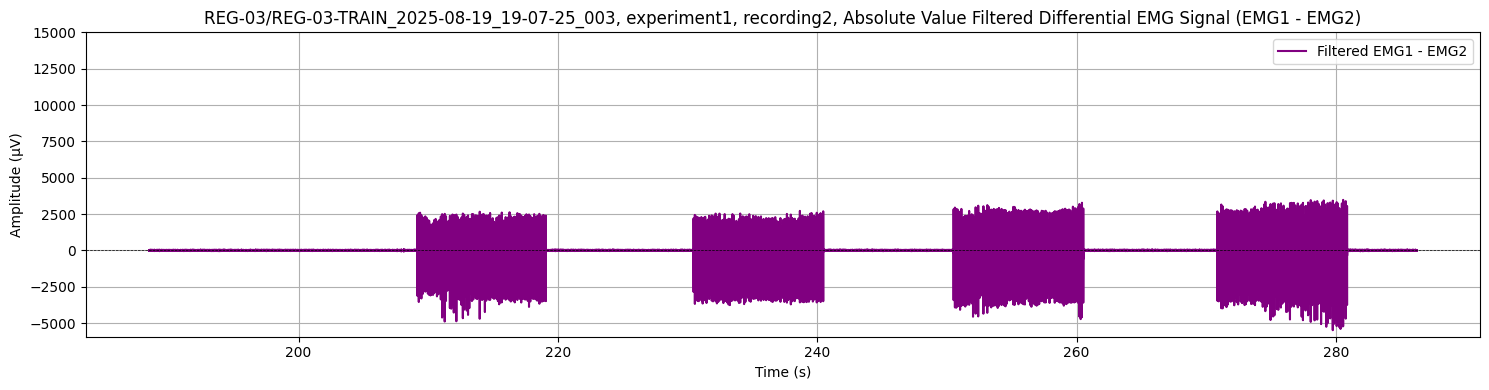

In [77]:
x = 1
exp = "experiment1"

y = f"recording{x + 1}"  # sequential label used in some parts of your code
yy = y
#y = f"recording{x}"  # sequential label used in some parts of your code
v = f"Record Node 106" if w == 0 else f"Record Node 111"
vv = f"Record Node 111" if u == 0 else f"Record Node 106"
i = 1

try:
    recording = session.recordnodes[w].recordings[x]
    #recording_offline = session.recordnodes[w].recordings[x]
except IndexError:
    print(f"No recording {x+1} found in {exp}/{yy}")
    

print(f"Processing: x={x}, y={y}, exp={exp}, yy={yy}")

# ==== Sync Setup ====
print(f"\n{exp.upper()}, Recording {x+1}")
print(recording)

# Only add sync line if a main one doesn't already exist
has_main_sync = any(sync.get("main", True) for sync in recording.sync_lines)
if not has_main_sync:
    recording.add_sync_line(1, 100, 'Rhythm Data', main=True)

recording.compute_global_timestamps()

metadata = recording.continuous[0].metadata
channel_names = metadata['channel_names']
print("Channels:", channel_names, '\n')

timestamps = recording.continuous[0].timestamps
#data_offline =  recording_offline.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(timestamps))
data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(timestamps))
sample_rate = metadata['sample_rate']

# ==== EMG Processing ====

differential_emg = data[:,3]
'''emg1_raw = data[:, 2]
emg2_raw = data[:, 3]
differential = (emg2_raw - emg1_raw)
lowcut = 100
highcut = 1000

b, a = butter(2, np.array([lowcut, highcut])/(sample_rate/2), btype='bandpass')


#y = lfilter(b, a, x) # only filters in the forward direction

differential_filt = lfilter(b, a, differential)
differential_abs = np.abs(differential_filt)
differential_emg = differential_filt'''

# ==== Load ADC1 (for stim detection) ====
adc1 = np.abs(data[:, 4])  # adjust if your ADC1 channel index differs

# ==== Sync Events ====
events = recording.events
sync_events = events[(events.line == 1) & (events.processor_id == 100) &
                        (events.stream_name == 'Rhythm Data') & (events.state == 1)]
sync_timestamps = sync_events['timestamp'].to_numpy()

# ==== Load MessageCenter ====
messagecenter_dir = os.path.join(directory, v, exp, yy, "events", "MessageCenter")
if not os.path.exists(messagecenter_dir):
    print(f"MessageCenter directory not found for {exp}/{yy}")
    

texts = np.load(os.path.join(messagecenter_dir, "text.npy"), allow_pickle=True)
timestamps_msg = np.load(os.path.join(messagecenter_dir, "timestamps.npy"))
decoded_texts = [t.decode('utf-8') if isinstance(t, bytes) else str(t) for t in texts]
message_entries = list(zip(timestamps_msg, decoded_texts))
print(f"Loaded {len(decoded_texts)} MessageCenter entries")

# ==== Debug Print ====
for text, time in zip(decoded_texts, timestamps_msg):
    print(f"[Time: {time:.6f} s] Message: {text}")

# ==== Full Trace Plot ====
plt.figure(figsize=(15, 4))
plt.plot(timestamps, differential_emg, label="Filtered EMG1 - EMG2", color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.title(f"{directory}, {exp}, {yy}, Absolute Value Filtered Differential EMG Signal (EMG1 - EMG2)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.grid(True)
plt.legend()
plt.ylim(top=15000)
plt.tight_layout()
plt.show()


In [62]:
# ==== Peri-Stimulus Analysis with Shaded Stimulus Duration ====
pre_event_time = 5   # ms before calculated stim start
post_event_time = 20 # ms after calculated stim start
stim_threshold = 0.1 # ADC1 threshold to detect pulse (adjust if needed)
offstim_threshold = 3

peri_stim_segments = []
peri_stim_segments_adc1 = []
segment_stim_end_times = []
segment_stim_start_times = []

In [63]:
for stamp in sync_timestamps:
        # First, find approximate sample index around the sync pulse
        #idx_start = np.searchsorted(timestamps, stamp)
        #idx_end   = np.searchsorted(timestamps, stamp + 0.010)
        #idx_center = (idx_start + idx_end)/2

        idx_search_start = np.searchsorted(timestamps, stamp - 0.00002)  # 10 ms before sync
        idx_search_end   = np.searchsorted(timestamps, stamp + 0.010)  # 10 ms after sync

        if idx_search_start < 0 or idx_search_end > len(timestamps):
            continue

        adc1_segment_for_detection = adc1[idx_search_start:idx_search_end]
        time_segment_for_detection = timestamps[idx_search_start:idx_search_end]

        # Detect true stim start: first crossing above threshold in that window
        above_idxs = np.where(adc1_segment_for_detection > stim_threshold)[0]
        
        if len(above_idxs) == 0:
            continue
        stim_start_idx = idx_search_start + above_idxs[0]
        stim_start_time = timestamps[stim_start_idx]

        # Now define peri-stimulus window around this stim_start_time
        idx_pre  = int(stim_start_idx - (pre_event_time / 1000) * sample_rate)
        idx_post = int(stim_start_idx + (post_event_time / 1000) * sample_rate)

        if idx_pre < 0 or idx_post > len(timestamps):
            continue

        # Extract windows
        time_window = timestamps[idx_pre:idx_post]
        time_zeroed = time_window - stim_start_time  # in seconds

        emg_window  = differential_emg[idx_pre:idx_post]
        adc1_window = adc1[idx_pre:idx_post]

        # Detect stim end: first time after stim_start where ADC1 falls back below threshold
        post_onset_mask = (time_zeroed >= 0)
        adc1_post_onset = adc1_window[post_onset_mask]
        time_post_onset = time_zeroed[post_onset_mask]

        below_idxs = np.where(adc1_post_onset < offstim_threshold)[0]
        if len(below_idxs) > 0:
            stim_end_time = time_post_onset[below_idxs[0]] * 1000  # convert to ms
        else:
            stim_end_time = post_event_time

        # Save for grouping
        peri_stim_segments.append((time_zeroed * 1000, emg_window, stim_end_time))
        peri_stim_segments_adc1.append(adc1_window)
        segment_stim_start_times.append(stim_start_time)
        segment_stim_end_times.append(stim_end_time)


In [64]:
print(time_window)
print(idx_search_start)
print(idx_search_end)
print(peri_stim_segments_adc1)
print(peri_stim_segments)
print(stim_end_time)
type(stim_end_time)

[280.852  280.8522 280.8524 280.8526 280.8528 280.853  280.8532 280.8534
 280.8536 280.8538 280.854  280.8542 280.8544 280.8546 280.8548 280.855
 280.8552 280.8554 280.8556 280.8558 280.856  280.8562 280.8564 280.8566
 280.8568 280.857  280.8572 280.8574 280.8576 280.8578 280.858  280.8582
 280.8584 280.8586 280.8588 280.859  280.8592 280.8594 280.8596 280.8598
 280.86   280.8602 280.8604 280.8606 280.8608 280.861  280.8612 280.8614
 280.8616 280.8618 280.862  280.8622 280.8624 280.8626 280.8628 280.863
 280.8632 280.8634 280.8636 280.8638 280.864  280.8642 280.8644 280.8646
 280.8648 280.865  280.8652 280.8654 280.8656 280.8658 280.866  280.8662
 280.8664 280.8666 280.8668 280.867  280.8672 280.8674 280.8676 280.8678
 280.868  280.8682 280.8684 280.8686 280.8688 280.869  280.8692 280.8694
 280.8696 280.8698 280.87   280.8702 280.8704 280.8706 280.8708 280.871
 280.8712 280.8714 280.8716 280.8718 280.872  280.8722 280.8724 280.8726
 280.8728 280.873  280.8732 280.8734 280.8736 280.8738

numpy.float64

In [69]:
# ==== Dynamically determine stimulation groups based on event messages ====

# First, extract only trigger messages and stim setting messages
trigger_pattern = re.compile(r"RHDCONTROL TRIGGER")
stim_pattern = re.compile(r"starting(?: at)? (\d+\.?\d*)\s*mA", re.IGNORECASE)

stim_groups = []
current_group = []
current_amp = None
trigger_times = []

for t, msg in message_entries:
    if stim_pattern.search(msg):
        # Save the previous group if any
        if current_amp is not None and current_group:
            stim_groups.append((current_amp, current_group))
        # Start new group
        current_amp = float(stim_pattern.search(msg).group(1))
        current_group = []
    elif trigger_pattern.search(msg):
        if current_amp is not None:
            current_group.append(t)

# Don't forget to save the last group
if current_amp is not None and current_group:
    stim_groups.append((current_amp, current_group))


In [70]:
# ==== Match trigger times to peri_stim_segments ====
# Create dictionary to associate each stim amplitude to its segments
stim_intensities = []
m_wave_peaks = []
h_wave_peaks = []

In [71]:
for stim_amp, trigger_times_group in stim_groups:
    # For each trigger time, find matching peri_stim segment (by start time)
    group_data = []
    group_start_times = []
    group_end_times = []
    group_adc1 = []

    for trig_time in trigger_times_group:
        # Find closest stim_start_time to this trigger time
        idx_match = np.argmin(np.abs(np.array(segment_stim_start_times) - trig_time))
        # Extra check: ensure it's reasonably close (e.g., within 100 ms)
        if abs(segment_stim_start_times[idx_match] - trig_time) < 0.1:
            group_data.append(peri_stim_segments[idx_match])
            group_adc1.append(peri_stim_segments_adc1[idx_match])
            group_start_times.append(segment_stim_start_times[idx_match])
            group_end_times.append(segment_stim_end_times[idx_match])

    if not group_data:
        continue  # skip if no valid matching data

    # Proceed with same logic as original
    time_ms_matrix = np.stack([gd[0] for gd in group_data])
    emg_matrix     = np.stack([gd[1] for gd in group_data])

    avg_time_ms = time_ms_matrix[0]  # identical for all in group
    avg_adc1 = np.mean(group_adc1, axis=0)
    avg_emg     = np.mean(emg_matrix, axis=0)
    avg_end_ms  = np.mean(group_end_times)

    stim_intensities.append(stim_amp)

    plt.figure(figsize=(7, 5))

    for (_, trace, _) in group_data:
        plt.plot(avg_time_ms, trace, color='red', alpha=0.6)
    plt.plot(avg_time_ms, avg_emg, color='black', linewidth=2, label='Average EMG')

    plt.axvline(x=0, color='red', linestyle='--', label='_nolegend_')
    plt.axvline(x=stim_end_time, color='red', linestyle='--', label='Stim Start/End')
    plt.axvspan(0, stim_end_time, color='red', alpha=0.3)

    

    plt.axvspan(m_wave_start, m_wave_end, color='blue', alpha=0.3)
    plt.axvspan(h_wave_start, h_wave_end, color='green', alpha=0.3)

    m_wave_mask = (avg_time_ms >= m_wave_start) & (avg_time_ms <= m_wave_end)
    m_wave_time_window = avg_time_ms[m_wave_mask]
    m_wave_emg_window = avg_emg[m_wave_mask]
    m_wave_peak_idx = np.argmax(m_wave_emg_window)
    m_wave_peak_time = m_wave_time_window[m_wave_peak_idx]
    m_wave_peak_amp = m_wave_emg_window[m_wave_peak_idx]
    m_wave_peaks.append(m_wave_peak_amp)

    h_wave_mask = (avg_time_ms >= h_wave_start) & (avg_time_ms <= h_wave_end)
    h_wave_time_window = avg_time_ms[h_wave_mask]
    h_wave_emg_window = avg_emg[h_wave_mask]
    h_wave_peak_idx = np.argmax(h_wave_emg_window)
    h_wave_peak_time = h_wave_time_window[h_wave_peak_idx]
    h_wave_peak_amp = h_wave_emg_window[h_wave_peak_idx]
    h_wave_peaks.append(h_wave_peak_amp)

    plt.axvline(x=m_wave_peak_time, color='blue', linestyle=':', linewidth=2,
                label=f'M-Wave Peak: {m_wave_peak_amp:.1f} μV at {m_wave_peak_time:.2f} ms')
    plt.axvline(x=h_wave_peak_time, color='green', linestyle=':', linewidth=2,
                label=f'H-Wave Peak: {h_wave_peak_amp:.1f} μV at {h_wave_peak_time:.2f} ms')

    plt.text(m_wave_peak_time, m_wave_peak_amp + 200, f'{m_wave_peak_amp:.1f} μV',
            color='blue', fontsize=9, ha='center')
    plt.text(h_wave_peak_time, h_wave_peak_amp + 200, f'{h_wave_peak_amp:.1f} μV',
            color='green', fontsize=9, ha='center')

    plt.title(f"{exp}, {yy}, Peri-Stimulus EMG "
            f"(Events {i}-{i + (1)*len(group_data)}) | Stim Amp: {stim_amp} mA")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (μV)")
    plt.grid(True)
    plt.legend(
        fontsize=7,
        loc="upper left",
        frameon=True,
        framealpha=0.8
    )
    plt.ylim(top=1500)

    min_ms = int(np.floor(avg_time_ms[0]))
    max_ms = int(np.ceil(avg_time_ms[-1]))
    plt.xticks(np.arange(min_ms, max_ms + 1, 1))

    plt.tight_layout()
    plt.show()
    i = i + (1)*len(group_data) + 1



In [72]:
for stim_amp, trigger_times_group in stim_groups: 
    group_data = []
    group_start_times = []
    group_end_times = []
    group_adc1 = []

    for trig_time in trigger_times_group:
        # Find closest stim_start_time to this trigger time
        idx_match = np.argmin(np.abs(np.array(segment_stim_start_times) - trig_time))
        if abs(segment_stim_start_times[idx_match] - trig_time) < 0.1:
            group_data.append(peri_stim_segments[idx_match])
            group_adc1.append(peri_stim_segments_adc1[idx_match])
            group_start_times.append(segment_stim_start_times[idx_match])
            group_end_times.append(segment_stim_end_times[idx_match])

    if not group_data:
        continue

    # Stack time and EMG data
    time_ms_matrix = np.stack([gd[0] for gd in group_data])
    emg_matrix     = np.stack([gd[1] for gd in group_data])
    avg_time_ms    = time_ms_matrix[0]
    avg_emg        = np.mean(emg_matrix, axis=0)
    avg_end_ms     = np.mean(group_end_times)

    stim_intensities.append(stim_amp)

    plt.figure(figsize=(8, 5))

    # Plot average EMG
   # plt.plot(avg_time_ms, avg_emg, color='black', linewidth=2, label='Average EMG')

    # Plot stim period once
    #plt.axvline(x=0, color='red', linestyle='--')
    #plt.axvline(avg_end_ms, color='red', linestyle='--')
    #plt.axvspan(0, avg_end_ms, color='red', alpha=0.3)

    # Plot M- and H-wave windows once
    #plt.axvspan(m_wave_start, m_wave_end, color='blue', alpha=0.3)
    #plt.axvspan(h_wave_start, h_wave_end, color='green', alpha=0.3)

    # --- Find peaks for each trial ---
    m_peaks = []
    h_peaks = []

    for trial_idx in range(len(group_data)):
        trial_emg = emg_matrix[trial_idx]

        # M-wave peak
        m_mask = (avg_time_ms >= m_wave_start) & (avg_time_ms <= m_wave_end)
        if np.any(m_mask):
            m_peak_idx = np.argmax(trial_emg[m_mask])
            m_peak_time = avg_time_ms[m_mask][m_peak_idx]
            m_peak_amp = trial_emg[m_mask][m_peak_idx]
            m_peaks.append(m_peak_amp)
            plt.scatter(trial_idx+1, m_peak_amp, color='blue', s=40)  # X = trial number

        # H-wave peak
        h_mask = (avg_time_ms >= h_wave_start) & (avg_time_ms <= h_wave_end)
        if np.any(h_mask):
            h_peak_idx = np.argmax(trial_emg[h_mask])
            h_peak_time = avg_time_ms[h_mask][h_peak_idx]
            h_peak_amp = trial_emg[h_mask][h_peak_idx]
            h_peaks.append(h_peak_amp)
            plt.scatter(trial_idx+1, h_peak_amp, color='green', s=40)  # X = trial number

    # Annotate average peaks across the group
    plt.axhline(np.mean(m_peaks), color='blue', linestyle=':', linewidth=1, label=f'M-Wave mean ({len(m_peaks)} trials)')
    plt.axhline(np.mean(h_peaks), color='green', linestyle=':', linewidth=1, label=f'H-Wave mean ({len(h_peaks)} trials)')

    plt.title(f"{exp}, {yy}, Peri-Stimulus EMG | Stim Amp: {stim_amp} mA")
    plt.xlabel("Time (ms) / Trial Index")
    plt.ylabel("Amplitude (μV)")
    plt.grid(True)
    plt.legend(fontsize=8, loc='upper left')
    #plt.ylim(top=400)
    plt.tight_layout()
    plt.show()


In [73]:
#avg_emg  = np.mean(group_emg, axis=0)
#avg_adc1 = np.mean(group_adc1, axis=0)
#avg_end_time = np.mean(segment_stim_end_times)
#print(trace)
#print(time_ms)
#print(avg_adc1)
#print(avg_emg)
#print(avg_end_time)
#print(segment_stim_start_times)
#print(group_emg)

In [74]:
# ==== Group and Normalize Peak Amplitudes ====
m_wave_dict = defaultdict(list)
h_wave_dict = defaultdict(list)

# Ensure all amplitudes are absolute values
for amp, m_peak, h_peak in zip(stim_intensities, m_wave_peaks, h_wave_peaks):
    m_wave_dict[amp].append(abs(m_peak))
    h_wave_dict[amp].append(abs(h_peak))

# Sort stimulation intensities
sorted_amps = sorted(set(stim_intensities))
m_wave_data = [m_wave_dict[amp] for amp in sorted_amps]
h_wave_data = [h_wave_dict[amp] for amp in sorted_amps]

# Compute means
m_means = np.array([np.mean(peaks) for peaks in m_wave_data])
h_means = np.array([np.mean(peaks) for peaks in h_wave_data])
m_sems  = np.array([stats.sem(peaks) for peaks in m_wave_data])
h_sems  = np.array([stats.sem(peaks) for peaks in h_wave_data])

# Find M_max and normalize amplitudes
M_max = np.max(m_means)
m_means_norm = (m_means / M_max) * 100
h_means_norm = (h_means / M_max) * 100
m_sems_norm  = (m_sems  / M_max) * 100
h_sems_norm  = (h_sems  / M_max) * 100

# Interpolate M-curve to find current at 50% M_max
from scipy.interpolate import interp1d

interp_func = interp1d(m_means_norm, sorted_amps, kind='linear', bounds_error=False, fill_value='extrapolate')
try:
    current_at_50_percent = float(interp_func(50))
except:
    current_at_50_percent = sorted_amps[np.argmax(m_means_norm >= 50)]

# Normalize current axis
normalized_currents = np.array(sorted_amps) / current_at_50_percent

# Mark H_max (point "a") and Current at H_max (point "b")
H_max = np.max(h_means_norm)
idx_Hmax = np.argmax(h_means_norm)
current_at_Hmax_norm = normalized_currents[idx_Hmax]

# ==== Plot Normalized Recruitment Curves ====
fig, ax = plt.subplots(figsize=(7, 5))

# Overlay normalized mean ± SEM
ax.errorbar(normalized_currents - 0.02, m_means_norm, yerr=m_sems_norm, fmt='o-', color='blue', label='M-Wave (% Mmax)')
ax.errorbar(normalized_currents + 0.02, h_means_norm, yerr=h_sems_norm, fmt='o-', color='green', label='H-Wave (% Mmax)')

# Add point "a" (H_max) and "b" (Current at H_max)
ax.axhline(H_max, color='green', linestyle='--', linewidth=1, label=f'H_max = {H_max:.1f}% Mmax')
ax.axvline(current_at_Hmax_norm, color='gray', linestyle='--', linewidth=1, label=f'Current at H_max = {current_at_Hmax_norm:.2f}x')

# Add labels
ax.text(current_at_Hmax_norm + 0.02, H_max + 2, 'b', fontsize=12, color='black')
ax.text(normalized_currents[idx_Hmax] - 0.08, H_max + 2, 'a', fontsize=12, color='black')

# Aesthetics
ax.set_xticks(np.round(normalized_currents, ))
ax.set_xticklabels([f"{x:.1f}" for x in normalized_currents])
ax.set_xlabel("Current (Normalized to Current at 50% Mmax)", fontsize=16)
ax.set_ylabel("H and M Wave Amplitude (% of Mmax)", fontsize=16)
ax.set_title(f"{exp}, {yy}, Normalized Recruitment Curves")
ax.grid(True)
ax.legend(fontsize=16)
#ax.set_xlim(right=1.4)
#ax.set_xlim(left=0)
plt.tight_layout()
plt.show()



regular_currents = np.array(sorted_amps)
H_max = np.max(h_means)
idx_Hmax_reg = np.argmax(h_means)
current_at_Hmax = regular_currents[idx_Hmax_reg] + 20.0

M_max = np.max(m_means)
idx_Mmax_reg = np.argmax(m_means)
current_at_Mmax = regular_currents[idx_Mmax_reg] + 31.5
# Normalize current axis


# ==== Plot Recruitment Curves as Box-and-Whisker ====
fig, ax = plt.subplots(figsize=(7, 5))



# Boxplots
positions = np.arange(len(sorted_amps))  # for spacing

#Overlay mean ± SEM
ax.errorbar(positions - 0.2, m_means, yerr=m_sems, fmt='o-', color='blue', label='M-Wave Mean ± SEM')
ax.errorbar(positions + 0.2, h_means, yerr=h_sems, fmt='o-', color='green', label='H-Wave Mean ± SEM')

# Overlay normalized mean ± SEM
#ax.errorbar(normalized_currents - 0.02, m_means_norm, yerr=m_sems_norm, fmt='o-', color='blue', label='M-Wave (% Mmax)')
#ax.errorbar(normalized_currents + 0.02, h_means_norm, yerr=h_sems_norm, fmt='o-', color='green', label='H-Wave (% Mmax)')


# Add point "a" (H_max) and "b" (Current at H_max)
#ax.axhline(M_max, color='black', linestyle='--', linewidth=1 )
#ax.axvline(current_at_Mmax, color='black', linestyle='--', linewidth=1)

#ax.axhline(M_max, color='black', linestyle='--', linewidth=1 )
#ax.axvline(current_at_Mmax, color='black', linestyle='--', linewidth=1)


## Add labels
#ax.text(current_at_Hmax - 3, H_max + 2, 'b', fontsize=30, color='black')
#ax.text(regular_currents[idx_Hmax] - 0.08, H_max + 2, 'a', fontsize=12, color='black')


# Aesthetics
ax.set_xticks(positions)
tick_labels = []
for i, amp in enumerate(sorted_amps):
    if i % 5 == 0:  # show every 10th label
        tick_labels.append(f"{amp:.2f}")
    else:
        tick_labels.append("")  # leave blank

ax.set_xticklabels(tick_labels)

#ax.set_xticklabels([f"{amp:.1f}" for amp in sorted_amps])
ax.set_xlabel("Stimulation Intensity (mA)", fontsize = 25)
ax.set_ylabel("Peak Amplitude (μV)", fontsize = 25)
#ax.set_title(f"{exp}, {yy}, Recruitment Curves")
ax.set_title("Recruitment Curves", fontsize=25)
ax.grid(True)
ax.legend(fontsize = 15)
ax.set_ylim(top=8500)
plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity